https://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import pandas as pd
import theano.tensor as T
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
SEED = 383561

np.random.seed(SEED) # from random.org, for reproducibility

In [3]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.]) # this is sigma. the std for the first value would be 0.5*0.5=0.25

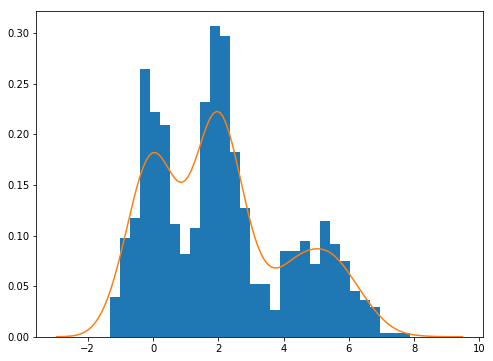

In [4]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=30, normed=True, lw=0)
sns.kdeplot(x)
plt.show()

We see a total of 3 subgroups with 3 different modes. 

Let's use the pymc3 Gaussian Mixture Model to try to predict the distribution for each. We can do this because all subgroups ~ Normal distribution

In [13]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 1, 5, shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [22]:
with model:
    trace = pm.sample(8000, tune=4000, n_init=10000, njobs=1)[5000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau_log__, mu, w_stickbreaking__]
100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:31<00:00, 131.26it/s]


In [23]:
pm.summary(trace, varnames=['w', 'mu', 'tau'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.260112,0.015871,0.000225,0.228544,0.290362,5021.840485,0.999834
w__1,0.404552,0.019818,0.000298,0.367062,0.443438,4828.392452,0.999833
w__2,0.335336,0.016419,0.000218,0.303805,0.368269,5980.555314,0.999834
mu__0,4.954155,0.088043,0.001285,4.782700,5.127709,4656.782438,1.000022
mu__1,2.012079,0.033887,0.000428,1.946080,2.076779,5748.237972,0.999835
mu__2,-0.050348,0.036524,0.000455,-0.125067,0.018489,5573.711261,0.999898
tau__0,0.985450,0.131120,0.001987,0.729648,1.237736,4371.939835,0.999903
tau__1,3.618169,0.472377,0.007128,2.700804,4.582785,4412.245255,0.999902
tau__2,3.537948,0.374151,0.005372,2.819271,4.277919,5648.169295,0.999933


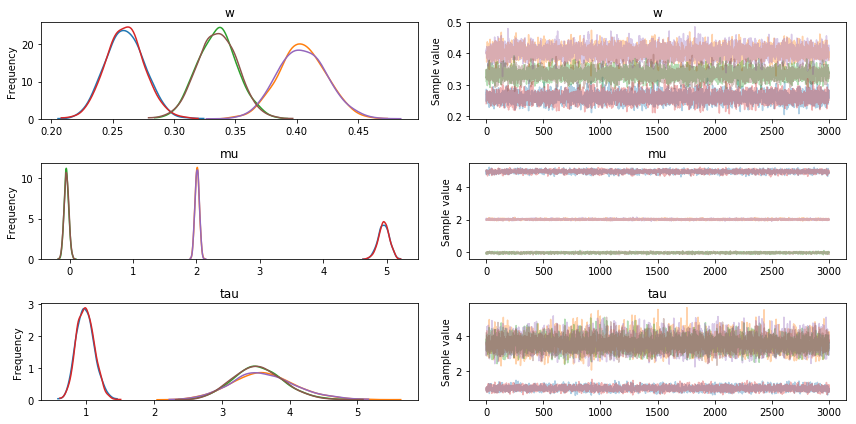

In [26]:
pm.traceplot(trace, varnames=['w', 'mu','tau']);

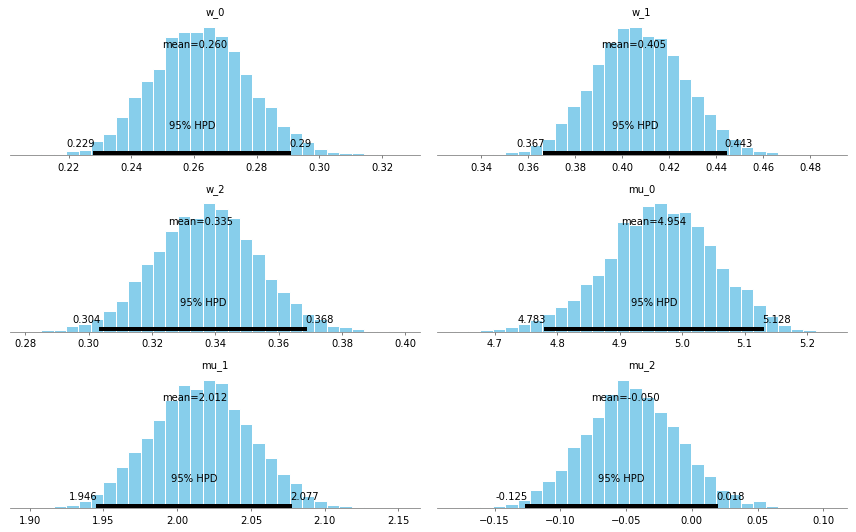

In [27]:
pm.plot_posterior(trace, varnames=['w', 'mu'], color='#87ceeb');

In [24]:
"""
This sample_ppc function will randomly draw 500 samples of parameters from the trace. Then, for each sample, 
it will draw 100 random numbers from a normal distribution specified by the values 
of mu and std in that sample.
"""

with model:
    ppc_trace = pm.sample_ppc(trace, 5000)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1386.19it/s]


**Use posterior predictive samples to analyze their similarity to the real observed data.**

In [22]:
ppc_trace['x_obs'].shape

(5000,)

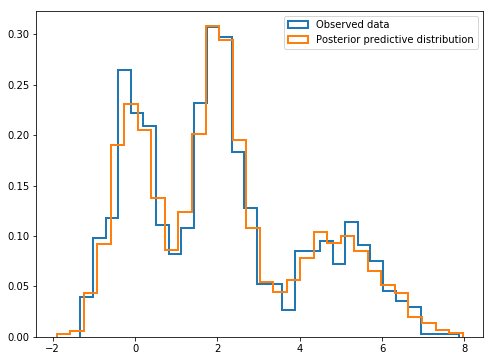

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);

#  Predictive analysis to determine the cluster probability of each value

**To predict the probability of value x (waiting times between eruptions of the Old Faithful geyser) belonging to cluster 0 or 1 or 2, we need to analyze the common area within the three normal distributions.**

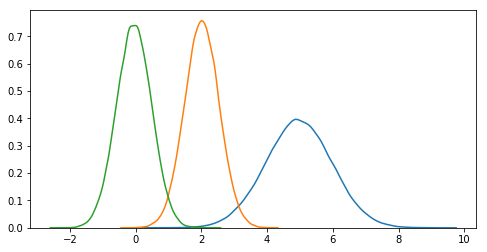

In [29]:
np.random.seed(seed=13)
plt.figure(figsize=(8,4))
cluster_0 = pm.Normal.dist(mu=trace['mu'][:,0].mean(), tau=trace['tau'][:,0].mean()).random(size=100000)
cluster_1 = pm.Normal.dist(mu=trace['mu'][:,1].mean(), tau=trace['tau'][:,1].mean()).random(size=100000)
cluster_2 = pm.Normal.dist(mu=trace['mu'][:,2].mean(), tau=trace['tau'][:,2].mean()).random(size=100000)

sns.kdeplot(cluster_0)
sns.kdeplot(cluster_1)
sns.kdeplot(cluster_2)

# plt.xlim(0.95, 1.0)
plt.show()

Suppose we observe a new data point, say `x=2.9`, and we wish to calculate the probability of it being assigned to cluster 0. Let's denote the assignment of x as Lx, which is equal to 0 or 1 or 2. We are interested in P(Lx=0|x=2.9).

According to Bayes theorem:
$$P(A\mid B) = \frac{P(B\mid A)P(A)}{P(B)}$$

In our case, A represents Lx=0 and B is the evidence we have: we observe that x=2.9 

We are interested in asking "Is the probability that x is in cluster 0 greater than the probability it is in cluster 1 and 2?", where the probability is dependent on the chosen parameters:
$$P(L_x=0\mid x=2.9) > ( P(L_x=1\mid x=2.9) + P(L_x=2\mid x=2.9) )$$

Which translates to:
$$\frac{P(x=2.9\mid L_x=0)P(L_x=0)}{P(x=2.9)} > \frac{P(x=2.9\mid L_x=1)P(L_x=1)}{P(x=2.9)} + \frac{P(x=2.9\mid L_x=2)P(L_x=2)}{P(x=2.9)}$$

As the denominators are equal, they can be ignored, so our formula is:

$${P(x=2.9\mid L_x=0)P(L_x=0)} > {P(x=2.9\mid L_x=1)P(L_x=1)} + {P(x=2.9\mid L_x=2)P(L_x=2)}$$

P(Lx=0) is equal to:

In [45]:
trace['w'][:,0]

array([0.25953903, 0.25492161, 0.25492161, ..., 0.24759217, 0.25821962,
       0.27143757])

**Probability of belonging to cluster Zero**

In [36]:
norm_pdf = stats.norm.pdf

prob_cluster_0 = trace['w'][:,0] # P(Lx=0)
prob_cluster_1 = trace['w'][:,1]
prob_cluster_2 = trace['w'][:,2]

std_0 = 1/trace['tau'][:,0]
std_1 = 1/trace['tau'][:,1]
std_2 = 1/trace['tau'][:,2]

x=2.9

v = norm_pdf(x, loc=trace['mu'][:,0], scale=std_0) * (prob_cluster_0) > \
    ((norm_pdf(x, loc=trace['mu'][:,1], scale=std_1) * (prob_cluster_1)) + \
    (norm_pdf(x, loc=trace['mu'][:,2], scale=std_2) * (prob_cluster_2))) 
    
print("Probability of value x=2.9 belonging to cluster zero: "+str(v.mean()))
print("\nCluster zero's standard deviation is 4 times bigger than the other two clusters. That is why 2.9 has \
higher probability of being part of cluster zero, even though the distributions intersect at 3.15 (meaning anything < 3.15 \
should, intuitively, belong to cluster two)")

Probability of value x=2.9 belonging to cluster zero: 0.8091666666666667

Cluster zero's standard deviation is 4 times bigger than the other two clusters. That is why 2.9 has higher probability of being part of cluster zero, even though the distributions intersect at 3.15 (meaning anything < 3.15 should, intuitively, belong to cluster two)


**Probability of belonging to cluster one**

In [40]:
x=1.1

v = norm_pdf(x, loc=trace['mu'][:,1], scale=std_1) * (prob_cluster_1) > \
    ((norm_pdf(x, loc=trace['mu'][:,0], scale=std_0) * (prob_cluster_0)) + \
    (norm_pdf(x, loc=trace['mu'][:,2], scale=std_2) * (prob_cluster_2))) 
    
print("Probability of belonging to cluster one (where mean is about 2) : "+str(v.mean()))

Probability of belonging to cluster one (where mean is about 2) : 0.8046666666666666
